<a href="https://colab.research.google.com/github/vd4mmind/googleColab/blob/ML_scRNASeq_SK_lab_2020/Day1__00_Advanced_Loading_and_preprocessing_scRNAseq_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loading and preprocessing

In this tutorial, we demonstrate how to process a 31,000 cell 27-day time course of embryoid body (EB) differentiation using scRNA-seq.

We review the following steps:

1. Loading 10X data  
2. Filtering
3. Normalization
4. Transformation

## 0. Introducing `scprep`

`scprep` is a lightweight scRNA-seq toolkit for `python` Data Scientists.

Most scRNA-seq toolkits are written in `R` (the most famous being [Seurat](https://satijalab.org/seurat/)), but we (and a majority of machine learning / data scientists) develop our tools in `python`. Currently, [Scanpy](https://icb-scanpy.readthedocs-hosted.com/en/stable/) is the most popular toolkit for scRNA-seq analysis in `python`. However, Scanpy has a highly structured framework for data representation that is incompatible with the bulk of the `python` data science framework, e.g. [pandas](https://pandas.pydata.org/), [SciPy](https://www.scipy.org/), and [scikit-learn](https://scikit-learn.org/stable/).

To accommodate users of the wider `python` data analysis ecosystem, we developed `scprep` (<b>s</b>ingle <b>c</b>ell <b>prep</b>aration). `scprep` makes it easier to use the pandas / SciPy / scikit-learn ecosystem for scRNA-seq analysis. Most of `scprep` is composed of helper functions to perform tasks common to single cell data like loading counts matrices, filtering & normalizing cells by library size, and calculating common statistics. The key advantage of `scprep` is that data can be stored in Pandas DataFrames, NumPy arrays, Scipy sparse matrices, and no matter which tools you choose to interface with, _it just works_.

To learn more about `scprep`, you can read the documentation at https://scprep.readthedocs.io/.

## 1. Install tools

To run this notebook, you need to download a couple of packages. Unfortunately, due to restrictions of Google CoLab, these installations won't be saved. A workaround can be found at the following link if you're interested: https://stackoverflow.com/questions/52582858/saving-pip-installs-in-google-colab

For now, simply run the following line of code by clicking on the code cell and hit `Shift` + `Enter`.

In [1]:
!pip install scprep tasklogger

     |████████████████████████████████| 102kB 3.1MB/s 


### Time course of human embryoid body differentation

Low passage H1 hESCs were maintained on Matrigel-coated dishes in DMEM/F12-N2B27 media supplemented with FGF2. For EB (Embriod Body) formation, cells were treated with Dispase, dissociated into small clumps and plated in non-adherent plates in media supplemented with 20% FBS, which was prescreened for EB differentiation. Samples were collected during 3-day intervals during a 27 day-long differentiation timecourse. An undifferentiated hESC sample was also included (Figure S7D). Induction of key germ layer markers in these EB cultures was validated by qPCR (data not shown). For single cell analyses, EB cultures were dissociated, FACS sorted to remove doublets and dead cells and processed on a 10x genomics instrument to generate cDNA libraries, which were then sequenced. Small scale sequencing determined that we have successfully collected data on approximately 31,000 cells equally distributed throughout the timecourse.

<a id='loading'></a>
## 2. Loading 10X data

### Downloading Data from Mendeley Datasets

The EB dataset is publically available as `scRNAseq.zip` at Mendelay Datasets at <https://data.mendeley.com/datasets/v6n743h5ng/>. 

Inside the scRNAseq folder, there are five subdirectories, and in each subdirectory are three files: `barcodes.tsv`, `genes.tsv`, and `matrix.mtx`. For more information about how CellRanger produces these files, check out the [Gene-Barcode Matrices Documentation](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/output/matrices).

Here's the directory structure:
```
download_path
└── scRNAseq
    ├── scRNAseq.zip
    ├── T0_1A
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T2_3B
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T4_5C
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    ├── T6_7D
    │   ├── barcodes.tsv
    │   ├── genes.tsv
    │   └── matrix.mtx
    └── T8_9E
        ├── barcodes.tsv
        ├── genes.tsv
        └── matrix.mtx
```

If you have downloaded the files already, set the `download_path` below to the directory where you saved the files. If not, the following code will download the data for you. Not that the download is 746MB: you must have sufficient disk space for the download.

**Please Note:** If you are trying to analyze data generated by a more recent version of `cellranger` (a program provided by 10X Genomics to go from raw fastq files to count matrices), the three files generated per sample are `barcodes.tsv.gz`, `features.tsv.gz`, and `matrix.mtx.gz`. The procedure for loading these files with `scprep` is the same as with the previous version.

In [2]:
import os
import scprep
download_path = os.path.expanduser("~")
print(download_path)

/root


In [0]:
if not os.path.isdir(os.path.join(download_path, "scRNAseq", "T0_1A")):
    scprep.io.download.download_and_extract_zip(
        url="https://data.mendeley.com/datasets/v6n743h5ng"
        "/1/files/7489a88f-9ef6-4dff-a8f8-1381d046afe3/scRNAseq.zip?dl=1",
        destination=download_path)

### Using `scprep` to import data into Pandas DataFrames


We use a toolkit for loading and manipulating single-cell data called `scprep`. The function `load_10X` will automatically load 10X scRNAseq datasets (and others) into a Pandas DataFrame. DataFrames are incredibly useful tools for data analysis in Python. To learn more about them, [check out the Pandas Documentation and Tutorials](https://pandas.pydata.org/pandas-docs/stable/).


Let's load the data and create a single matrix that we can use for preprocessing, visualization, and analysis.

### 2.1. Standard imports

We'll import these few packages at the beginning of nearly every session.

In [0]:
import pandas as pd
import numpy as np
import scprep

import matplotlib.pyplot as plt

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

### 2.2. Use `scprep.io.load_10X` to import all three matrices into a DataFrame

#### Understanding the difference between sparse and dense data

By default, `scprep.io.load_10X` loads scRNA-seq data using the Pandas DataFrame with sparse columns [(**see Pandas docs**)](https://pandas.pydata.org/pandas-docs/stable/user_guide/sparse.html) to maximize memory efficiency. However, this will be slower than loading on a dense matrix. Let's have a look at how long it takes to load the data from the first time point and how much memory it uses with dense and sparse data. We'll use `tasklogger` to measure how long each loading step takes.

In [5]:
import tasklogger
import pickle

# load data in dense format
with tasklogger.log_task("dense"):
    data_time1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"),
                                    sparse=False, gene_labels='both')
    
# measure the size of the matrix with pickle
print("Size: {:.1f}MB".format(len(pickle.dumps(data_time1)) / 1024**2))

# load data in sparse format
with tasklogger.log_task("sparse"):
    data_time1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"),
                                    sparse=True, gene_labels='both')
    
# measure the size of the matrix with pickle
print("Size: {:.1f}MB".format(len(pickle.dumps(data_time1)) / 1024**2))

Calculating dense...
Calculated dense in 16.66 seconds.
Size: 1196.5MB
Calculating sparse...
Calculated sparse in 26.08 seconds.
Size: 122.8MB


So for a small penalty in computation time, we can save a lot of memory. If memory is limited (for example, on Google Colaboratory) it's recommended that you use the sparse format.

You'll also notice that we've received a warning (above in red) that the gene symbols are not unique. This doesn't cause a problem with the dense data, but it does with the sparse. We can specify `gene_labels='both'` to ask for our column names as `SYMB (ENSID)` which gives us both the human readability of symbols but also the uniqueness of Ensembl IDs.

#### Understanding the data matrix

How big is our matrix? We can find out with `data.shape`.

In [6]:
data_time1.shape

(4649, 33694)

We have 4,700 cells (rows) and 33,600 genes (columns). Each row and column has a name associated with it.

The _columns_ refer to the genes, of features of the data. `data.columns` gives these as a list.

In [7]:
data_time1.columns

Index(['RP11-34P13.3 (ENSG00000243485)', 'FAM138A (ENSG00000237613)',
       'OR4F5 (ENSG00000186092)', 'RP11-34P13.7 (ENSG00000238009)',
       'RP11-34P13.8 (ENSG00000239945)', 'RP11-34P13.14 (ENSG00000239906)',
       'RP11-34P13.9 (ENSG00000241599)', 'FO538757.3 (ENSG00000279928)',
       'FO538757.2 (ENSG00000279457)', 'AP006222.2 (ENSG00000228463)',
       ...
       'AC007325.2 (ENSG00000277196)', 'BX072566.1 (ENSG00000277630)',
       'AL354822.1 (ENSG00000278384)', 'AC023491.2 (ENSG00000278633)',
       'AC004556.1 (ENSG00000276345)', 'AC233755.2 (ENSG00000277856)',
       'AC233755.1 (ENSG00000275063)', 'AC240274.1 (ENSG00000271254)',
       'AC213203.1 (ENSG00000277475)', 'FAM231B (ENSG00000268674)'],
      dtype='object', length=33694)

The _rows_ refer to the cells, of observations of the data. `data.index` gives these as a list.

In [8]:
data_time1.index

Index(['AAACATACCAGAGG-1', 'AAACATTGAAAGCA-1', 'AAACATTGAAGTGA-1',
       'AAACATTGGAGGTG-1', 'AAACATTGGTTTCT-1', 'AAACCGTGCAGAAA-1',
       'AAACCGTGGAAGGC-1', 'AAACCGTGGCTACA-1', 'AAACGCACCGGTAT-1',
       'AAACGCACCTATTC-1',
       ...
       'TTTCGAACCCTCGT-1', 'TTTCGAACGTCCTC-1', 'TTTCTACTATCGAC-1',
       'TTTGACTGAACGTC-1', 'TTTGACTGCTCAAG-1', 'TTTGACTGCTTCTA-1',
       'TTTGACTGTGCCCT-1', 'TTTGCATGAGGTCT-1', 'TTTGCATGGGCGAA-1',
       'TTTGCATGTGACAC-1'],
      dtype='object', name=0, length=4649)

Note that some tools expect the opposite: that genes would be on the rows and cells on the columns. This is a hold-over from bulk RNA-seq, when it made sense for each replicate (of which there were few) to be a feature and each gene (of which there were many) to be an observation; however, now that we can have as many or more cells than genes, it makes more sense for cells to be observations. Keep this difference in mind when you try new tools.

Finally, we can view the actual matrix, either by simply typing the matrix name to view the whole thing, or using the `.head()` function to view the first few rows.

In [9]:
data_time1.head(10)

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP5-857K21.15 (ENSG00000236743),RP4-669L17.2 (ENSG00000236601),RP4-669L17.10 (ENSG00000237094),OR4F29 (ENSG00000278566),RP5-857K21.4 (ENSG00000230021),RP5-857K21.2 (ENSG00000235146),OR4F16 (ENSG00000273547),RP11-206L10.4 (ENSG00000229905),RP11-206L10.9 (ENSG00000237491),FAM87B (ENSG00000177757),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),RP11-54O7.16 (ENSG00000272438),RP11-54O7.1 (ENSG00000230699),RP11-54O7.2 (ENSG00000241180),RP11-54O7.3 (ENSG00000223764),SAMD11 (ENSG00000187634),NOC2L (ENSG00000188976),KLHL17 (ENSG00000187961),PLEKHN1 (ENSG00000187583),PERM1 (ENSG00000187642),RP11-54O7.17 (ENSG00000272512),HES4 (ENSG00000188290),ISG15 (ENSG00000187608),RP11-54O7.11 (ENSG00000224969),AGRN (ENSG00000188157),RP11-54O7.18 (ENSG00000273443),RNF223 (ENSG00000237330),C1orf159 (ENSG00000131591),LINC01342 (ENSG00000223823),...,MT-CO1 (ENSG00000198804),MT-CO2 (ENSG00000198712),MT-ATP8 (ENSG00000228253),MT-ATP6 (ENSG00000198899),MT-CO3 (ENSG00000198938),MT-ND3 (ENSG00000198840),MT-ND4L (ENSG00000212907),MT-ND4 (ENSG00000198886),MT-ND5 (ENSG00000198786),MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),AC133551.1 (ENSG00000274175),AC136612.1 (ENSG00000275869),AC136616.1 (ENSG00000273554),AC136616.3 (ENSG00000278782),AC136616.2 (ENSG00000277761),AC141272.1 (ENSG00000277836),AC136352.5 (ENSG00000277666),AC136352.4 (ENSG00000276760),AC171558.2 (ENSG00000275249),AC171558.1 (ENSG00000274792),BX004987.4 (ENSG00000278704),AC145212.4 (ENSG00000277400),AC145212.2 (ENSG00000274847),AC011841.1 (ENSG00000273496),AC011043.1 (ENSG00000276256),AC011043.2 (ENSG00000278198),AL592183.1 (ENSG00000273748),AC007325.1 (ENSG00000276017),AC007325.4 (ENSG00000278817),AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAACATACCAGAGG-1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,59,69,0,18,45,3,0,28,9,2,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACATTGAAAGCA-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,49,27,1,14,42,1,0,18,7,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACATTGAAGTGA-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,21,18,0,8,17,1,0,9,5,0,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACATTGGAGGTG-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,20,29,0,17,16,0,0,8,3,1,17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACATTGGTTTCT-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,45,35,0,12,38,2,0,11,1,0,21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCGTGCAGAAA-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,24,33,0,8,22,0,0,12,4,0,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCGTGGAAGGC-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,33,44,0,25,59,3,0,33,3,1,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACCGTGGCTACA-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,2,0,1,3,1,0,2,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACGCACCGGTAT-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,...,39,28,0,23,54,3,0,23,3,1,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

#### Loading the whole dataset

Now we know how to load the data, let's load the data matrix for each sample (this may take a few minutes). Note that [`scprep.io`](https://scprep.readthedocs.io/en/stable/reference.html#module-scprep.io) has a range of different input functions: csv, tsv, mtx, and fcs are also available.

In [10]:
sparse=True
data_time1 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T0_1A"), sparse=sparse, gene_labels='both')
data_time2 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T2_3B"), sparse=sparse, gene_labels='both')
data_time3 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T4_5C"), sparse=sparse, gene_labels='both')
data_time4 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T6_7D"), sparse=sparse, gene_labels='both')
data_time5 = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", "T8_9E"), sparse=sparse, gene_labels='both')
data_time5.head()

,RP11-34P13.3 (ENSG00000243485),FAM138A (ENSG00000237613),OR4F5 (ENSG00000186092),RP11-34P13.7 (ENSG00000238009),RP11-34P13.8 (ENSG00000239945),RP11-34P13.14 (ENSG00000239906),RP11-34P13.9 (ENSG00000241599),FO538757.3 (ENSG00000279928),FO538757.2 (ENSG00000279457),AP006222.2 (ENSG00000228463),RP5-857K21.15 (ENSG00000236743),RP4-669L17.2 (ENSG00000236601),RP4-669L17.10 (ENSG00000237094),OR4F29 (ENSG00000278566),RP5-857K21.4 (ENSG00000230021),RP5-857K21.2 (ENSG00000235146),OR4F16 (ENSG00000273547),RP11-206L10.4 (ENSG00000229905),RP11-206L10.9 (ENSG00000237491),FAM87B (ENSG00000177757),LINC00115 (ENSG00000225880),FAM41C (ENSG00000230368),RP11-54O7.16 (ENSG00000272438),RP11-54O7.1 (ENSG00000230699),RP11-54O7.2 (ENSG00000241180),RP11-54O7.3 (ENSG00000223764),SAMD11 (ENSG00000187634),NOC2L (ENSG00000188976),KLHL17 (ENSG00000187961),PLEKHN1 (ENSG00000187583),PERM1 (ENSG00000187642),RP11-54O7.17 (ENSG00000272512),HES4 (ENSG00000188290),ISG15 (ENSG00000187608),RP11-54O7.11 (ENSG00000224969),AGRN (ENSG00000188157),RP11-54O7.18 (ENSG00000273443),RNF223 (ENSG00000237330),C1orf159 (ENSG00000131591),LINC01342 (ENSG00000223823),...,MT-CO1 (ENSG00000198804),MT-CO2 (ENSG00000198712),MT-ATP8 (ENSG00000228253),MT-ATP6 (ENSG00000198899),MT-CO3 (ENSG00000198938),MT-ND3 (ENSG00000198840),MT-ND4L (ENSG00000212907),MT-ND4 (ENSG00000198886),MT-ND5 (ENSG00000198786),MT-ND6 (ENSG00000198695),MT-CYB (ENSG00000198727),AC133551.1 (ENSG00000274175),AC136612.1 (ENSG00000275869),AC136616.1 (ENSG00000273554),AC136616.3 (ENSG00000278782),AC136616.2 (ENSG00000277761),AC141272.1 (ENSG00000277836),AC136352.5 (ENSG00000277666),AC136352.4 (ENSG00000276760),AC171558.2 (ENSG00000275249),AC171558.1 (ENSG00000274792),BX004987.4 (ENSG00000278704),AC145212.4 (ENSG00000277400),AC145212.2 (ENSG00000274847),AC011841.1 (ENSG00000273496),AC011043.1 (ENSG00000276256),AC011043.2 (ENSG00000278198),AL592183.1 (ENSG00000273748),AC007325.1 (ENSG00000276017),AC007325.4 (ENSG00000278817),AC007325.2 (ENSG00000277196),BX072566.1 (ENSG00000277630),AL354822.1 (ENSG00000278384),AC023491.2 (ENSG00000278633),AC004556.1 (ENSG00000276345),AC233755.2 (ENSG00000277856),AC233755.1 (ENSG00000275063),AC240274.1 (ENSG00000271254),AC213203.1 (ENSG00000277475),FAM231B (ENSG00000268674)
0,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AAACATACACCCAA-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,1,0,3,3,0,1,5,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACATACCGAGTT-1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,1,0,4,4,0,0,4,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACATACGTAGCT-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,77,20,0,6,17,1,0,21,5,1,16,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACATACGTCCTC-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,7,6,0,2,2,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
AAACATACTGGAAA-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,3,0,1,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 2.3. Library size filtering

#### Why we filter cells by library size
In scRNA-seq the library size of a cell is the number of unique mRNA molecules detected in that cell. These unique molecules are identified using a random barcode incorporated during the first round of reverse transcription. This barcode is called a <b>U</b>nique <b>M</b>olecule <b>I</b>dentifier, and often we refer to the number unique mRNAs in a cell as the number of UMIs. To read more about UMIs, [Smith *et al.* (2017)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5340976/) write about how sequencing errors and PCR amplification errors lead to innaccurate quantification of UMIs/cell.

Depending on the method of scRNA-seq, the amount of library size filtering done can vary. The 10X Genomics CellRanger tool, the DropSeq and InDrops pipelines, and the Umitools package each have their own method and cutoff for determining real cells from empty droplets. Additional methods exist for trying to detect the difference between droplets containing one cell and droplets containing two cells ("doublets"). You can take these methods at face value or set some manual cutoffs based on your data.

#### Visualing the library size distribution using `scprep`

There is a helper function for plotting library size from a gene expression matrix in scprep called [`scprep.plot.plot_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_library_size).

Let's have a look at the library size for the first time point. In this sample we see that there is a small number of cells with very small library sizes and a long tail of cells that have very high library sizes.

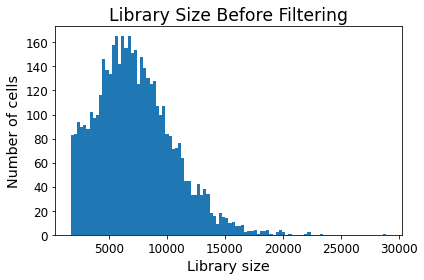

In [11]:
scprep.plot.plot_library_size(data_time1,
                              log=False, title='Library Size Before Filtering')

Choose cutoffs above and below the main bulk of cells, removing cells that are both significantly smaller than average and significantly larger than average. You can plot the result by running `scprep.plot.plot_library_size` with `cutoff=(low, high)` or `percentile=(low, high)` where low and high are values or percentiles that you choose.

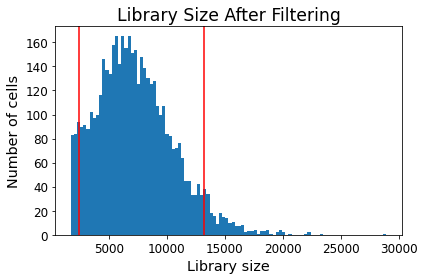

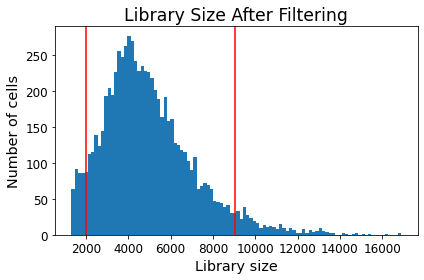

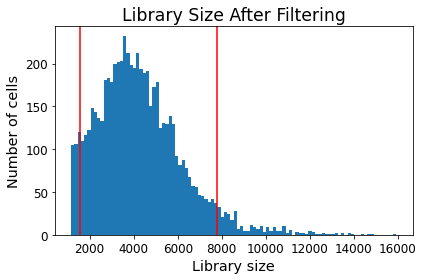

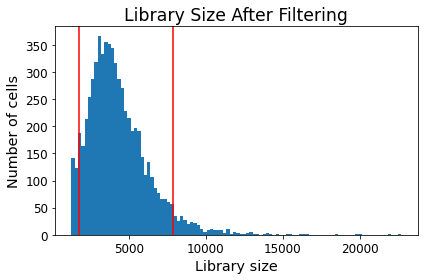

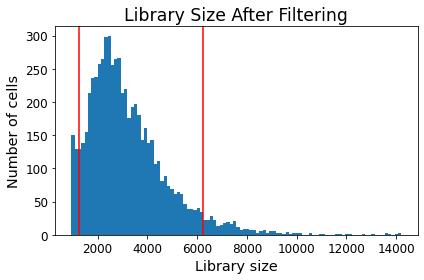

In [13]:
# =============
# Select appropriate percentiles (percentile=(low, high))
# for filtering and plot the result
percentile=(5,95)
scprep.plot.plot_library_size(data_time1,
                              log=False, title='Library Size After Filtering',percentile=percentile)
scprep.plot.plot_library_size(data_time2,
                              log=False, title='Library Size After Filtering',percentile=percentile)
scprep.plot.plot_library_size(data_time3,
                              log=False, title='Library Size After Filtering',percentile=percentile)
scprep.plot.plot_library_size(data_time4,
                              log=False, title='Library Size After Filtering',percentile=percentile)
scprep.plot.plot_library_size(data_time5,
                              log=False, title='Library Size After Filtering',percentile=percentile)
# =============

#### Selecting a cutoff

Several papers describe strategies for picking a maximum and minimum threshold that can be found with a quick Google search for "library size threshold single cell RNA seq".

Most of these pick an arbitrary measure such as a certain number of deviations below or above the mean or median library size. We find that spending too much time worrying about the exact threshold is inefficient, as results tend to be robust to filtering beyond some minimum threshold.

For the above dataset, we recommend removing all cells with more than 12,000 UMI / cell in fear they might represent doublets of cells. We generally also remove all cells with fewer than 1000 UMIs per cell.

### Exercise 1 - Filtering cells by library size

You can do this using [`scprep.filter.filter_library_size()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.filter.filter_library_size).

In [0]:
filtered_batches = []
for batch in [data_time1, data_time2, data_time3, data_time4, data_time5]:
    # ==================
    # fill in your chosen `percentile` values
    percentiles = (5,95)
    batch = scprep.filter.filter_library_size(batch, percentile=percentiles)
    # ==================
    filtered_batches.append(batch)
#del data_time1, data_time2, data_time3, data_time4, data_time5 # removes objects from memory

**Note:** If you are going to use `percentile` filter, you need to do the filtering individually for each sample.  If you are going to do filtering using hard numbers like _remove all cells with more than 12000 UMI/cell,_ you can do it for all the data together.

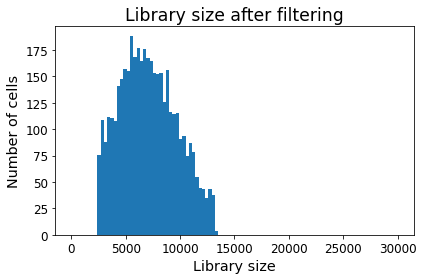

In [15]:
scprep.plot.plot_library_size(filtered_batches[0], log=False, range=(0,30000),
                              title='Library size after filtering')

The library size distribution is now much more constrained, which will reduce the effects of differences in library size (which can affect your results, even after normalization).

### 2.4. Merge all datasets and create a vector representing the time point of each sample

Now that we have filtered the datasets by library size, we can combine them into a single matrix. You can do this with [`scprep.utils.combine_batches()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.utils.combine_batches).

In [16]:
data, sample_labels = scprep.utils.combine_batches(
    filtered_batches, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"]
)
del filtered_batches # removes objects from memory
data.shape

(28038, 33694)

After combining batches, we have ~25,000 cells and 33,700 genes. Let's have a quick look at the combined matrix.

In [17]:
data.head()

,A1BG (ENSG00000121410),A1BG-AS1 (ENSG00000268895),A1CF (ENSG00000148584),A2M (ENSG00000175899),A2M-AS1 (ENSG00000245105),A2ML1 (ENSG00000166535),A2ML1-AS1 (ENSG00000256661),A2ML1-AS2 (ENSG00000256904),A3GALT2 (ENSG00000184389),A4GALT (ENSG00000128274),A4GNT (ENSG00000118017),AAAS (ENSG00000094914),AACS (ENSG00000081760),AADAC (ENSG00000114771),AADACL2 (ENSG00000197953),AADACL2-AS1 (ENSG00000242908),AADACL3 (ENSG00000188984),AADACL4 (ENSG00000204518),AADAT (ENSG00000109576),AAED1 (ENSG00000158122),AAGAB (ENSG00000103591),AAK1 (ENSG00000115977),AAMDC (ENSG00000087884),AAMP (ENSG00000127837),AANAT (ENSG00000129673),AAR2 (ENSG00000131043),AARD (ENSG00000205002),AARS (ENSG00000090861),AARS2 (ENSG00000124608),AARSD1 (ENSG00000266967),AASDH (ENSG00000157426),AASDHPPT (ENSG00000149313),AASS (ENSG00000008311),AATBC (ENSG00000215458),AATF (ENSG00000275700),AATK (ENSG00000181409),AATK-AS1 (ENSG00000225180),AB015752.3 (ENSG00000254180),AB019440.50 (ENSG00000271201),ABALON (ENSG00000281376),...,ZSCAN20 (ENSG00000121903),ZSCAN21 (ENSG00000166529),ZSCAN22 (ENSG00000182318),ZSCAN23 (ENSG00000187987),ZSCAN25 (ENSG00000197037),ZSCAN26 (ENSG00000197062),ZSCAN29 (ENSG00000140265),ZSCAN30 (ENSG00000186814),ZSCAN31 (ENSG00000235109),ZSCAN32 (ENSG00000140987),ZSCAN4 (ENSG00000180532),ZSCAN5A (ENSG00000131848),ZSCAN5B (ENSG00000197213),ZSCAN5CP (ENSG00000204532),ZSCAN9 (ENSG00000137185),ZSWIM1 (ENSG00000168612),ZSWIM2 (ENSG00000163012),ZSWIM3 (ENSG00000132801),ZSWIM4 (ENSG00000132003),ZSWIM5 (ENSG00000162415),ZSWIM6 (ENSG00000130449),ZSWIM7 (ENSG00000214941),ZSWIM8 (ENSG00000214655),ZSWIM8-AS1 (ENSG00000272589),ZUFSP (ENSG00000153975),ZW10 (ENSG00000086827),ZWILCH (ENSG00000174442),ZWINT (ENSG00000122952),ZXDA (ENSG00000198205),ZXDB (ENSG00000198455),ZXDC (ENSG00000070476),ZYG11A (ENSG00000203995),ZYG11B (ENSG00000162378),ZYX (ENSG00000159840),ZZEF1 (ENSG00000074755),ZZZ3 (ENSG00000036549),bP-21264C1.2 (ENSG00000278932),bP-2171C21.3 (ENSG00000279501),bP-2189O9.3 (ENSG00000279579),hsa-mir-1253 (ENSG00000272920)
AAACATACCAGAGG-1_Day 00-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,1,1,0,0,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
AAACATTGAAAGCA-1_Day 00-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
AAACATTGAAGTGA-1_Day 00-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
AAACATTGGAGGTG-1_Day 00-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,0,0,0
AAACATTGGTTTCT-1_Day 00-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,4,0,0,0,0,0,0,0,0,0,0,0,0


Now we have one matrix containing all five time points of the experiment, and a vector (`sample_labels`) telling us which cells (rows) came from which time point. As you can see, the time point is also appended to the cell barcode.

In [18]:
sample_labels

AAACATACCAGAGG-1_Day 00-03    Day 00-03
AAACATTGAAAGCA-1_Day 00-03    Day 00-03
AAACATTGAAGTGA-1_Day 00-03    Day 00-03
AAACATTGGAGGTG-1_Day 00-03    Day 00-03
AAACATTGGTTTCT-1_Day 00-03    Day 00-03
                                ...    
TTTGCATGCACTCC-1_Day 24-27    Day 24-27
TTTGCATGTAGACC-1_Day 24-27    Day 24-27
TTTGCATGTGTCGA-1_Day 24-27    Day 24-27
TTTGCATGTTCTAC-1_Day 24-27    Day 24-27
TTTGCATGTTCTTG-1_Day 24-27    Day 24-27
Name: sample_labels, Length: 28038, dtype: object

Finally, because the Google Colab client is not the most powerful client, we'll subsample this dataset to allow you to run the preprocessing steps a little more quickly.

In [0]:
data, sample_labels = scprep.select.subsample(data, sample_labels, n=10000)

In [21]:
data.shape, sample_labels.shape

((10000, 33694), (10000,))

#### Batch effects

It's worth noting here that we have combined five different experiments into one data matrix here, and in doing so potentially exposed ourself to a "batch effect". A batch effect is a difference (technical or biological) between two batches of an experiment. This can be caused by systematic error (e.g. a difference in temperature during library preparation) or a genuine biological effect of interest (e.g. in this case each batch is sampled at a different time of development.)

Correcting for technical / systematic batch effects is a topic unto itself which we will cover later in the workshop; however it's worth noting that any time we combine multiple experiments, we should check to see if they are substantially different and compare this to our expectations. If the effect is large and unexpected, we can either a) attempt to correct it / account for it using computational methods, or b) modify our analysis to avoid combining the datasets.

### Discussion

1. Why do we remove cells with low UMI count (or library size)?
2. Why do we remove cells with high UMI count (or library size)?

<a id='preprocessing'></a>
## 3. Preprocessing: Filtering, Normalizing, and Transforming

All of these steps are carried out on the whole combined data.

### Filtering

We filter the data by: 
1. Removing dead cells  
2. Filtering by library size (if we did not do this prior to combining batches)
3. Removing genes that are expressed in relatively few cells.

### 3.1 Dead cell removal

#### What does high mitochondrial gene expression indicate?

Generally, we assume that cells with high detection of mitochondrial RNAs have undergone degradation of the mitochondrial membrane as a result of apoptosis. This may be from stress during dissociation, culture, or really anywhere in the experimental pipeline. As with the high and low library size cells, we want to remove the long tail from the distribution. In a successful experiment, it's typical for 5-10% of the cells to have this apoptotic signature.

#### Plotting mitochondrial expression

Let's look at the mitochondrial expression. You can do this using [`scprep.plot.plot_gene_set_expression()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_gene_set_expression), which conveniently gets you the list of mitochrondrial genes by name using the helper function [`scprep.select.get_gene_set()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.select.get_gene_set).

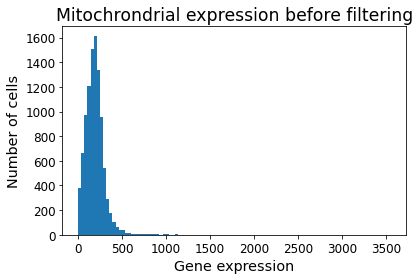

In [22]:
# Plot all mitochondrial genes. There are 14, FYI.
scprep.plot.plot_gene_set_expression(data, starts_with="MT-",
                                     library_size_normalize=True,
                                     title="Mitochrondrial expression before filtering")

Here we see that above some threshold, there is a steep increase in expression of mitochondrial RNAs. We'll remove these cells from further analysis. Choose a cut-off based on the histogram above and plot your chosen value on a new histogram.

### Exercise 2 - filtering dead cells by mitochondrial expression

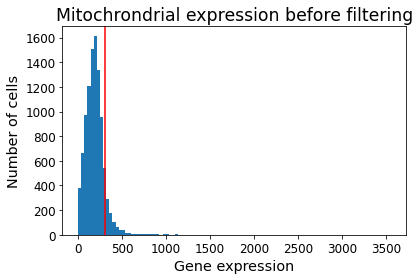

In [23]:
# ================
# choose a cutoff at which to plot a red line such that you
# remove cells with aberrant mitochondrial expression
#scprep.plot.plot_gene_set_expression(data, starts_with="MT-",
                                    # library_size_normalize=True,
                                     #title="Mitochrondrial expression before filtering",
                                    # cutoff =
scprep.plot.plot_gene_set_expression(data, starts_with="MT-",
                                     library_size_normalize=True,
                                     title="Mitochrondrial expression before filtering",
                                     percentile=90)
# ================

Now we can remove those cells.

In [24]:
# ================
# Fill in your chosen cutoff value
#cutoff = 
percentile=90
# ================
data_filt, sample_labels = scprep.filter.filter_gene_set_expression(
    data, sample_labels, starts_with="MT-",
    percentile=percentile, keep_cells='below', library_size_normalize=True)
data_filt.shape

(9000, 33694)

After removing the top 10\% of cells by mitochrondrial expression, we're left with 9,000 cells. Let's look at that histogram again.

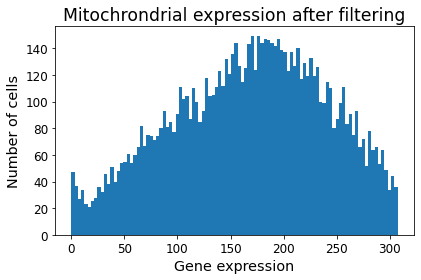

In [25]:
scprep.plot.plot_gene_set_expression(data_filt, starts_with="MT-",
                                     library_size_normalize=True,
                                     title="Mitochrondrial expression after filtering")

Much better! We have a tight distribution without a long tail, indicating that all of our cells have relatively normal mitochondrial expression.

### 3.2 - Filtering lowly expressed genes

#### Why remove lowly expressed genes?

Capturing RNA from single cells is a noisy process. The first round of reverse transcription is done in the presence of cell lysate. This results in capture of only 10-40% of the mRNA molecules in a cell leading to a phenomenon called dropout where some lowly expressed genes are not detected in cells in which they are expressed [[1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR13), [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR44), [3](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR64), [4](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5561556/#CR65)]. As a result, some genes are so lowly expressed (or expressed not at all) that we do not have sufficient observations of that gene to make any inferences on its expression.

Lowly expressed genes that may only be represented by a handful of mRNAs may not appear in a given dataset. Others might only be present in a small number of cells. Because we lack sufficient information about these genes, we remove lowly expressed genes from the gene expression matrix during preprocessing. Typically, if a gene is detected in only very few cells, it gets removed.

Here, we can see that in EB dataset, there are many genes that are detected in very few cells.

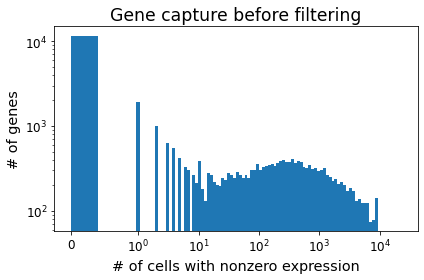

In [26]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt), log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

Again, we see a relatively clean distribution on the right (genes observed in many cells) with a heavy tail on the right (rare genes). Where would you choose to cut this off?

### Exercise 3 - filtering rare genes

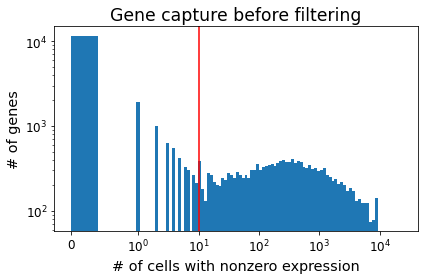

In [29]:
# ================
# choose a cutoff
scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt), cutoff = 10,
                      log=True,
                      title="Gene capture before filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')
# ================

Let's go ahead and remove those genes.

In [0]:
# ================
# choose a cutoff
cutoff = 10
data_filt = scprep.filter.filter_rare_genes(data_filt, min_cells=cutoff)
# ================

We can plot the above histogram again for good measure. As you can see, the rare genes are all gone.

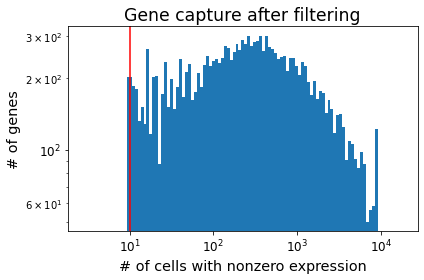

In [31]:
scprep.plot.histogram(scprep.measure.gene_capture_count(data_filt), cutoff=cutoff, log=True,
                      title="Gene capture after filtering",
                     xlabel='# of cells with nonzero expression',
                     ylabel='# of genes')

In [32]:
data_filt.shape

(9000, 16425)

After filtering, we have removed many thousands of genes. This will be our last filtering step, though you can always filter out aberrant expression on an ad hoc basis. As it stands, we've quite significantly reduced our dataset from 10,000 x 33,000 that we started with. And that's not even counting the cells we removed by library size before combining time points!

### 3.3 - Normalization

As you saw during filtering, the range of library sizes between cells can be quite extreme. We visualized this for one time point pre-filtering, but let's now visualize the whole dataset, post-filtering.

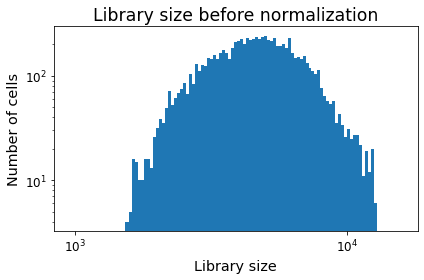

In [33]:
scprep.plot.plot_library_size(data_filt, title='Library size before normalization')

To correct for differences in library sizes, we divide each cell by its library size and then rescale by the a fixed value, sometimes the median library size. The default in `scprep` is to rescale every cell to 10,000 counts to make numbers comparable across datasets.

In python this is performed using the preprocessing method [`scprep.normalize.library_size_normalize()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.normalize.library_size_normalize).

In [0]:
data_norm, library_size = scprep.normalize.library_size_normalize(data_filt, return_library_size=True)

If you plot the library sizes again, you'll see they are all the same.

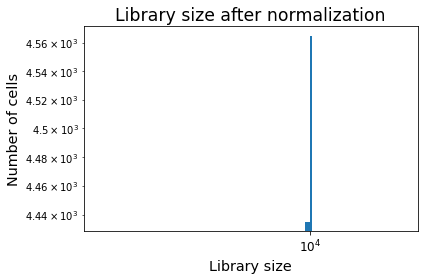

In [35]:
scprep.plot.plot_library_size(data_norm, title='Library size after normalization')

#### Creating the `metadata` DataFrame

You'll notice now we have two metadata objects: `sample_labels` and `library_size`. We can make our lives easier by putting these into a DataFrame as follows.

In [36]:
metadata = pd.concat([library_size, sample_labels], axis=1)
metadata

,library_size,sample_labels
AAACATTGGTTTCT-1_Day 00-03,10383.0,Day 00-03
AAACGCTGGGTTAC-1_Day 00-03,12123.0,Day 00-03
AAAGATCTCTGCTC-1_Day 00-03,5462.0,Day 00-03
AAAGATCTGGTACT-1_Day 00-03,8795.0,Day 00-03
AAAGGCCTAACCGT-1_Day 00-03,6287.0,Day 00-03
...,...,...
TTTCGAACGTTCTT-1_Day 24-27,3746.0,Day 24-27
TTTCGAACTTCGGA-1_Day 24-27,4531.0,Day 24-27
TTTCTACTCTTATC-1_Day 24-27,2453.0,Day 24-27
TTTCTACTTGAGCT-1_Day 24-27,2329.0,Day 24-27


### 3.4 - Gene Count Transformation

In scRNA-seq analysis, we often see that some genes are orders of magnitude more common than others. Let's have a look at the mean expression of each gene.

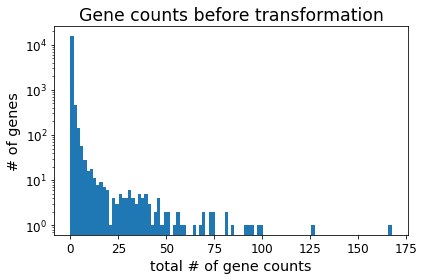

In [37]:
scprep.plot.histogram(data_norm.mean(axis=0), log='y',
                      title="Gene counts before transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

In order to avoid these high-expression genes dominating the variation, the data is often $\log$-transformed. This typically requires the addition of some small value to avoid taking $\log(0)$. We avoid this issue entirely by instead taking the square root transform. The square root function has a similar form as the $\log$ function with the added benefit of being stable at 0.

In [0]:
data_sqrt = scprep.transform.sqrt(data_norm)

After transformation, you should see that the mean expression values are now much closer together.

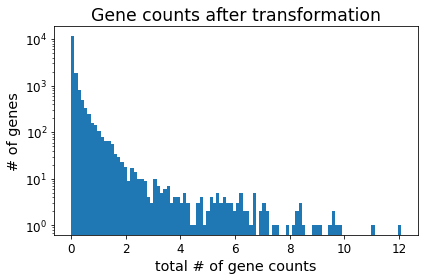

In [39]:
scprep.plot.histogram(data_sqrt.mean(axis=0), log='y',
                      title="Gene counts after transformation",
                     xlabel='total # of gene counts',
                     ylabel='# of genes')

### 3.5 - Selecting highly variable genes

Many workflows involve just selecting highly variable genes. Gene variability is defined as the variance relative to the expected variance for a given gene mean, or "standardized variance". That is, genes with high mean have naturally higher variance simply due to their magnitude; we are interested in the genes that vary more than one would expect by random chance.

You can plot the standardized variance with [`scprep.plot.plot_gene_variability()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.plot.plot_gene_variability).

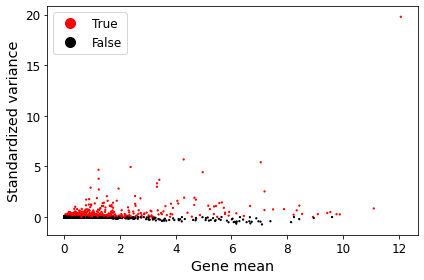

In [40]:
scprep.plot.plot_gene_variability(data_sqrt, percentile=90)

If you wish to select just the highly variable genes, you can do so with [`scprep.select.highly_variable_genes()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.select.highly_variable_genes).

In [0]:
data_hvg = scprep.select.highly_variable_genes(data_sqrt, percentile=90)

In [42]:
data_hvg.shape

(9000, 1643)

Unsurprisingly, we're now left with just 1,800 genes. This reduced size dataset can be useful for, for example, dimensionality reduction and clustering, which we will cover later in the workshop.

Finally, let's save the preprocessed data (we keeping all the genes, not just the highly variable ones) for later use.

In [0]:
data_sqrt.to_pickle("embryoid_body_data.pickle.gz")
metadata.to_pickle("embryoid_body_metadata.pickle.gz")

### Discussion

1. Why do we remove cells with high mitochondrial expression?
2. Why do we remove genes with non-zero expression in very few cells?
3. Why do we normalize expression by library size?
4. Why do we apply a sublinear transformation (e.g. `sqrt` or `log`) to the normalized expression?

## Summary

To summarize, we've preprocessed our data as follows:

1. Filter by library size to remove empty droplets and doublets
2. Combine batches
3. Filter out rarely expressed genes
4. Filter cells with high mitochrondrial expression
5. Normalize by library size
6. Square root transform
7. (Optional) Select highly variable genes

## 4. What happens if we don't preprocess correctly?

We can compare the results of preprocessing by examining the data after dimensionality reduction (e.g. PCA, t-SNE, UMAP, PHATE). We'll learn more about these methods later, but for now, let's see what trends we can see in the data with and without correct preprocessing.

In [44]:
!pip install phate

     |████████████████████████████████| 419kB 5.1MB/s 
     |████████████████████████████████| 51kB 4.8MB/s 
     |████████████████████████████████| 1.8MB 17.2MB/s 


#### Loading a subset of the data

To make things faster, we'll use a smaller subset of the data for this section in dense data format.

In [0]:
import phate

sparse=True
data_batches = []
for time in ["T0_1A", "T2_3B", "T4_5C", "T6_7D", "T8_9E"]:
    timepoint_data = scprep.io.load_10X(os.path.join(download_path, "scRNAseq", time),
                                        sparse=False, gene_labels='both')
    data_batches.append(scprep.select.subsample(timepoint_data, n=500))

del timepoint_data

#### End-to-end preprocessing pipeline

We've summarized the entire preprocessing pipeline below. Each run should take around a minute.

In [0]:
# library size filter
data = []
for batch in data_batches:
    batch = scprep.filter.filter_library_size(batch, percentile=(10, 90))
    data.append(batch)

# combine batches
data, sample_labels = scprep.utils.combine_batches(
    data, 
    ["Day 00-03", "Day 06-09", "Day 12-15", "Day 18-21", "Day 24-27"]
)

# store library size and put it into a metadata dataframe
libsize = scprep.measure.library_size(data)
metadata = pd.concat([sample_labels, libsize], axis=1)

# filter by mitochrondrial expression
data, metadata = scprep.filter.filter_gene_set_expression(
    data, metadata, starts_with="MT-",
    percentile=90, keep_cells='below', library_size_normalize=True)

# remove rare genes
data = scprep.filter.filter_rare_genes(data, cutoff=0, min_cells=10)

# normalize
data = scprep.normalize.library_size_normalize(data)

# transform
data = scprep.transform.sqrt(data)

# highly variable genes
data_hvg = scprep.select.highly_variable_genes(data, percentile=90)

# dimensionality reduction for visualization
data_phate = phate.PHATE(verbose=False).fit_transform(data_hvg)

#### Plot the results

We show the PHATE plot below with the following colorings:

* Time point - we expect the time points to show a progression from early to late, with late points showing more heterogeneity
* Library size - ideally there is relatively little variation between cells due to library size
* HAND1 - this gene is a marker of cardiac progenitors
* SOX2 - this gene is a marker of neural crest cells
* Mitochondrial expression - this is a marker of apoptosis

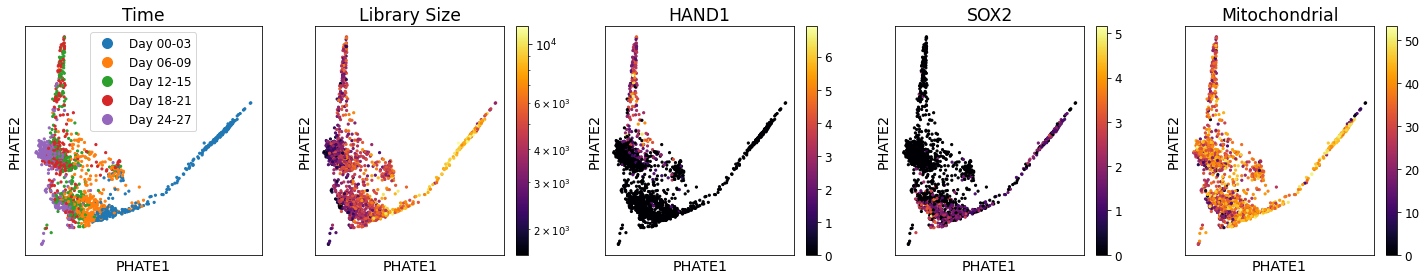

In [47]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], title='Time',
                      ticks=False, ax=axes[0], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=metadata['library_size'], title='Library Size', cmap_scale='log',
                      ticks=False, ax=axes[1], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=scprep.select.select_cols(data, exact_word="HAND1"), title='HAND1',
                      ticks=False, ax=axes[2], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=scprep.select.select_cols(data, exact_word="SOX2"), title='SOX2',
                      ticks=False, ax=axes[3], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=scprep.measure.gene_set_expression(data, starts_with="MT-"), title='Mitochondrial',
                      ticks=False, ax=axes[4], label_prefix='PHATE')
plt.tight_layout()

### Exercise: what happens if you modify the preprocessing workflow?

Choose a step of the preprocessing workflow and modify it. Select different thresholds or remove the step altogether and see what happens. Compare to the others in your group to see the effect of different steps.

In [48]:
# library size filter
data = []
for batch in data_batches:
    # ==========
    # filter the batch by library size percentiles
    batch_filt = 
    # alternatives: percentile=20, percentile=(20,80), percentile=5, percentile=0
    # ==========
    data.append(batch_filt)

# ===========
# combine batches
data, sample_labels = 
# ===========

# ===========
# store library size and put it into a metadata dataframe
libsize = 
metadata = 
# ===========

# ===========
# filter by mitochrondrial expression
data, metadata =
# alternative: percentile=80, percentile=99, percentile=100
# ===========

# ===========
# remove rare genes
data = 
# alternative: min_cells=1, min_cells=50
# ===========

# ===========
# normalize
data = 
# ===========

# ===========
# sqrt transform
data = 
# alternatives: scprep.transform.log, scprep.transform.arcsinh
# ===========

# ===========
# highly variable genes
data_hvg = 
# alternative: percentile=80, percentile=99, percentile=100
# ===========

# dimensionality reduction for visualization
data_phate = phate.PHATE().fit_transform(data_hvg)

SyntaxError: ignored

#### Plot the results

We show the PHATE plot below with the following colorings:

* Time point - we expect the time points to show a progression from early to late, with late points showing more heterogeneity
* Library size - ideally there is relatively little variation between cells due to library size
* HAND1 - this gene is a marker of cardiac progenitors
* SOX2 - this gene is a marker of neural crest cells
* Mitochondrial expression - this is a marker of apoptosis

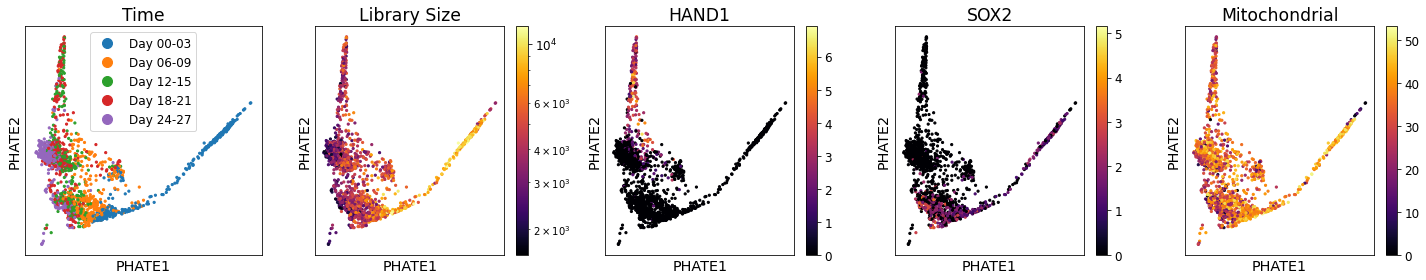

In [49]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
scprep.plot.scatter2d(data_phate, c=metadata['sample_labels'], title='Time',
                      ticks=False, ax=axes[0], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=metadata['library_size'], title='Library Size', cmap_scale='log',
                      ticks=False, ax=axes[1], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=scprep.select.select_cols(data, exact_word="HAND1"), title='HAND1',
                      ticks=False, ax=axes[2], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=scprep.select.select_cols(data, exact_word="SOX2"), title='SOX2',
                      ticks=False, ax=axes[3], label_prefix='PHATE')
scprep.plot.scatter2d(data_phate, c=scprep.measure.gene_set_expression(data, starts_with="MT-"), title='Mitochondrial',
                      ticks=False, ax=axes[4], label_prefix='PHATE')
plt.tight_layout()

### Discussion

Which parts of the preprocessing workflow had the largest effect on the output?

Where do the cells with high mitochondrial expression lie on the plot when they are not filtered out? Can you think of a situation where this might be different?

Which preprocessing steps affect the visibility of the cardiac and neural crest populations?

### Question responses and survey

Once you've finished the notebook, please take a 2-3 minutes to anonymously submit your responses and complete our daily course survey at the following URL: [https://forms.gle/ufCsKgp2jd5KD2Dv5](https://forms.gle/ufCsKgp2jd5KD2Dv5)